In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler
import matplotlib.pyplot as plt

In [2]:
class SumMNIST(Dataset):
    def __init__(self, mnist_dataset, im_per_epoch=60_000):
        self.mnist_dataset = mnist_dataset
        self.im_per_epoch = im_per_epoch
        
        if im_per_epoch > len(mnist_dataset):
            replacement = True
        else:
            replacement = False
            
        self.sample_im1 = list(RandomSampler(mnist_dataset, replacement=replacement, num_samples=im_per_epoch))
        self.sample_im2 = list(RandomSampler(mnist_dataset, replacement=replacement, num_samples=im_per_epoch))
        
    def __len__(self):
        return self.im_per_epoch
        
        
    def __getitem__(self,idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        digit1, label1 = self.mnist_dataset[self.sample_im1[idx]]
        digit2, label2 = self.mnist_dataset[self.sample_im2[idx]]
        
        return digit1, digit2, label1 + label2
    

In [3]:

def get_train_test_loader():
    batch_size = 64
    # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), (0, 0.3081, ))])
    # transform = transforms.Compose(transforms.ToTensor())

    train_dataset = datasets.MNIST(root='../dataset', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.MNIST(root='../dataset/', train=False, download=True, transform=transforms.ToTensor())
    
    train_datasetS = SumMNIST(train_dataset, im_per_epoch=60_000)
    test_datasetS = SumMNIST(test_dataset, im_per_epoch=60_000)
    
    train_loader = DataLoader(train_datasetS, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_datasetS, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

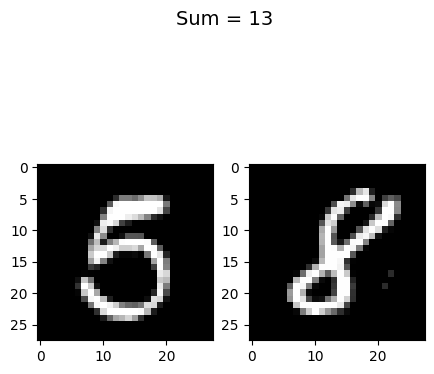

In [4]:
# plot images

if __name__ == '__main__':
    train_loader, test_loader = get_train_test_loader()
    
    for im1, im2, sum in train_loader:
        im1 = im1[0]
        im2 = im2[0]
        
        fig = plt.figure(figsize=(5, 5))
        fig.suptitle(f'Sum = {sum[0].numpy()}', fontsize=14)
        plt.subplot(1, 2, 1)
        plt.imshow(im1.squeeze().numpy(), cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(im2.squeeze().numpy(), cmap='gray')
        plt.show()
        break 

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
#  create the model
class SumNet(nn.Module):
    def __init__(self):
        super(SumNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) # 9216
    
        self.concat_layer1 = nn.Linear(256, 256) # 256, 256
        self.concat_layer2 = nn.Linear(256, 19) # 256, 19
        
        
    def forward_one_image(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
    
    def forward(self, im1, im2):
        embedding_im1 = self.forward_one_image(im1)
        embedding_im2 = self.forward_one_image(im2)
        embedding_concat = torch.cat((embedding_im1, embedding_im2), 1)
        embedding = self.concat_layer1(embedding_concat)
        embedding = F.relu(embedding)
        embedding = self.concat_layer2(embedding)
        output = F.log_softmax(embedding, dim=1)
        return output
        

        

In [7]:
## train 

def train(model, device, train_loader, optimizer, num_epochs):
    weight = torch.tensor([100/min(k + 1, 19 - k) for k in range(19)])
    weight = weight.to(device)
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (im1, im2, target) in enumerate(train_loader):
            im1, im2, target = im1.to(device), im2.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(im1, im2)
            
            loss = F.nll_loss(output, target, weight=weight)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print('[{}/{}], [{}/{}], loss={: .4f}'.format(epoch, num_epochs, batch_idx, len(train_loader), loss))




In [8]:
#  test 
def test(model, device, test_loader):
    model.eval()
    weight = torch.tensor([100 / min(k + 1, 19 - k) for k in range(19)])
    weight = weight.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for im1, im2, target in test_loader:
            im1, im2, target = im1.to(device), im2.to(device), target.to(device)
            outputs = model(im1, im2)
            
            test_loss += F.nll_loss(outputs, target, weight=weight, reduction='sum')
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum()
            
    test_loss /= len(test_loader.dataset)
    accuracy = correct/len(test_loader.dataset)
        
    print('Average loss:{:4f}, Accuracy:{:4f}'.format(test_loss, accuracy))

        


In [9]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, test_loader = get_train_test_loader()
    model = SumNet().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    num_epochs = 3
    train(model, device, train_loader, optimizer, num_epochs)
    test(model, device, test_loader)

[0/3], [0/938], loss= 2.9478
[0/3], [100/938], loss= 1.6247
[0/3], [200/938], loss= 0.7761
[0/3], [300/938], loss= 0.4815
[0/3], [400/938], loss= 0.1924
[0/3], [500/938], loss= 0.3491
[0/3], [600/938], loss= 0.4521
[0/3], [700/938], loss= 0.2615
[0/3], [800/938], loss= 0.1788
[0/3], [900/938], loss= 0.1237
[1/3], [0/938], loss= 0.2441
[1/3], [100/938], loss= 0.2399
[1/3], [200/938], loss= 0.2085
[1/3], [300/938], loss= 0.3249
[1/3], [400/938], loss= 0.1485
[1/3], [500/938], loss= 0.2379
[1/3], [600/938], loss= 0.2213
[1/3], [700/938], loss= 0.0495
[1/3], [800/938], loss= 0.1201
[1/3], [900/938], loss= 0.2562
[2/3], [0/938], loss= 0.0556
[2/3], [100/938], loss= 0.1402
[2/3], [200/938], loss= 0.0545
[2/3], [300/938], loss= 0.1207
[2/3], [400/938], loss= 0.0735
[2/3], [500/938], loss= 0.0992
[2/3], [600/938], loss= 0.0745
[2/3], [700/938], loss= 0.0665
[2/3], [800/938], loss= 0.1702
[2/3], [900/938], loss= 0.0942
Average loss:2.074242, Accuracy:0.963283
